In [ ]:
# Veri setini almak için Google Drive bağlantısı Yapıyoruz.
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Gerekli kütüphaneleri projeye import ediyoruz.
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [ ]:
# Model eğitinde kullanılacak Hiperparametreleri belirliyoruz.
IMG_SIZE = 224 # Veri setinde ki resimleri 224x224 boyutuna getiriliyor.
BATCH_SIZE = 32 # Her eğitim adımında 32 resim kullanılıyor.
EPOCHS = 15 #Verisetini 15 defa dönecek.
LEARNING_RATE = 0.0001 # Öğrenme hızı

# Google Drive'daki veri yollarını veriyoruz.
train_dir = '/content/drive/MyDrive/Covid_Dataset/train'
val_dir = '/content/drive/MyDrive/Covid_Dataset/val'

print("Yükelme Tamamlandı")

Yükelme Tamamlandı


In [ ]:
# Veri artırma (augmentation) ve normalizasyon
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Eğitim verisi için gerçek veri artırma
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Piksel değerleri [0, 255] → [0, 1] arasına normalize edilir.
    rotation_range=15,         # Görüntü 15 dereceye kadar rastgele döndürülür.
    width_shift_range=0.1,     # Genişlikte %10 kaydırılır.
    height_shift_range=0.1,    # Yükseklikte %10 kaydırılır.
    zoom_range=0.1,            # Yakınlaştırma işlemi yapıyoruz.
    horizontal_flip=True,      # Yatay çevirme işlemi yapıyoruz.
    fill_mode='nearest'        # Boşlukları en yakın piksel ile dolduruyoruz.
)

# Doğrulama verisi için sadece normalizasyon işlemi yapılıyor.
val_datagen = ImageDataGenerator(rescale=1./255)

# Verileri oluşturuyoruz.
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("Veri artırma ve ayarlama tamamlandı.")


Found 3050 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Veri artırma ve ayarlama tamamlandı.


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,739 (56.38 MB)

 Trainable params: 14,780,739 (56.38 MB)

 Non-trainable params: 0 (0.00 B)

Model Derleme Tamamlandı


In [ ]:
from tensorflow.keras.applications import VGG19, NASNetLarge, Xception,  ResNet152V2

MODEL_NAME = "ResNet152V2"  # Eğitilcek modeli seçiyoruz.



if MODEL_NAME == "VGG19":
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
elif MODEL_NAME == "VGG16":
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
elif MODEL_NAME == "Xception":
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
elif MODEL_NAME == "ResNet152V2":
    base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
else:
    raise ValueError("Geçersiz MODEL_NAME seçimi!")

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])


from tensorflow.keras.optimizers import Adam, RMSprop, SGD

# Farklı deneyler için:
# optimizer = Adam(learning_rate=LEARNING_RATE)
optimizer = SGD(learning_rate=LEARNING_RATE, momentum=0.9)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Model özetini yazdırıyoruz.
model.summary()


print("Model Derleme Tamamlandı")


234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152v2 (Functional)        │ (None, 7, 7, 2048)     │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,594,307 (223.52 MB)

 Trainable params: 58,450,563 (222.97 MB)

 Non-trainable params: 143,744 (561.50 KB)

Model Derleme Tamamlandı


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping nesnesini tanımlıyoruz.
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Modeli eğitiyoruz.
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stop]
)

Epoch 1/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.4069 - loss: 1.1881 - val_accuracy: 0.6450 - val_loss: 0.7885
Epoch 2/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 73s 755ms/step - accuracy: 0.7141 - loss: 0.6542 - val_accuracy: 0.7317 - val_loss: 0.5832
Epoch 3/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 71s 738ms/step - accuracy: 0.7864 - loss: 0.4931 - val_accuracy: 0.8217 - val_loss: 0.4202
Epoch 4/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 72s 744ms/step - accuracy: 0.8195 - loss: 0.4172 - val_accuracy: 0.8750 - val_loss: 0.3491
Epoch 5/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 73s 758ms/step - accuracy: 0.8391 - loss: 0.3822 - val_accuracy: 0.8650 - val_loss: 0.3289
Epoch 6/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 71s 741ms/step - accuracy: 0.8755 - loss: 0.3294 - val_accuracy: 0.8550 - val_loss: 0.3111
Epoch 7/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 71s 740ms/step - accuracy: 0.8912 - loss: 0.2894 - val_accuracy: 0.8683 - val_loss: 0.3093
Epoch 8/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 72s 746ms/step - accuracy: 0.8993 - loss: 0.2648 - val_accura

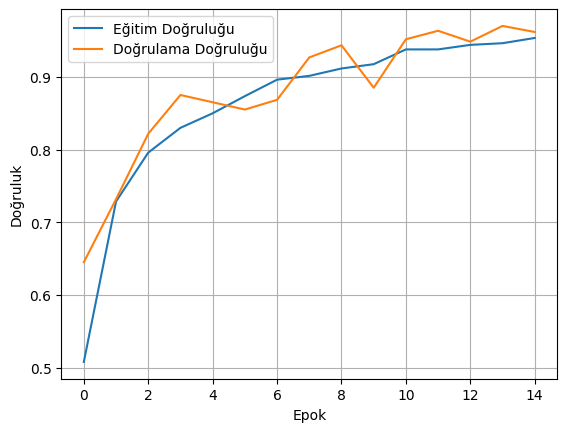

19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 670ms/step


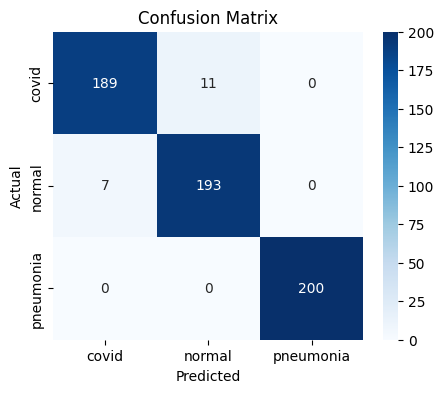

              precision    recall  f1-score   support

       covid       0.96      0.94      0.95       200
      normal       0.95      0.96      0.96       200
   pneumonia       1.00      1.00      1.00       200

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600



In [ ]:
# Confusion Matrix oluşturuyoruz.
val_generator.reset()
pred = model.predict(val_generator)
predicted_classes = np.argmax(pred, axis=1)
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Confusion matrix çiziyoruz.
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification değerlerini yazdırıyoruz.
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


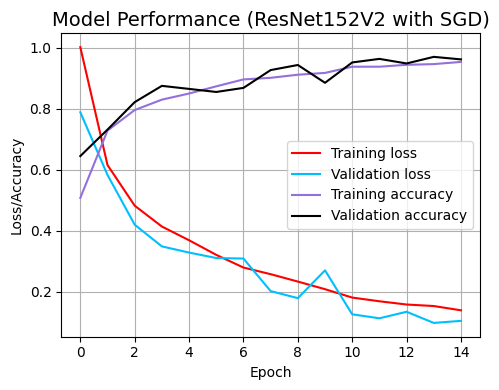

In [ ]:
import matplotlib.pyplot as plt

# Model eğitim sürecinde her epochda val ve los değerlerini nasaıl değiştiğini grafiksel olarak görmek için 4 değer bulunan bir grafik çiziyoruz.

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(5, 4))
plt.plot(epochs_range, loss, 'r', label='Training loss')
plt.plot(epochs_range, val_loss, 'deepskyblue', label='Validation loss')
plt.plot(epochs_range, acc, 'mediumpurple', label='Training accuracy')
plt.plot(epochs_range, val_acc, 'k', label='Validation accuracy')

plt.title('Model Performance (ResNet152V2 with SGD)', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import pandas as pd

# Tahminler
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Gerçek etiketler
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Doğruluk
overall_acc = accuracy_score(y_true, y_pred)
print(f"\n Overall Accuracy: {overall_acc:.4f}\n")

# Classification report (precision, recall, f1)
report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(" Classification Report (Precision, Recall, F1-score):\n")
print(report_df[['precision', 'recall', 'f1-score']])

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\n Confusion Matrix:")
print(cm)

# Specificity hesaplama
specificities = {}
for i in range(len(class_labels)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FN + FP)
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    specificities[class_labels[i]] = specificity

# Tabloyu genişlet
report_df['specificity'] = pd.Series(specificities)
print("\n Full Report (with Specificity):")
print(report_df[['precision', 'recall', 'f1-score', 'specificity']].iloc[:len(class_labels)])


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step

✅ Overall Accuracy: 0.9700

📊 Classification Report (Precision, Recall, F1-score):

              precision  recall  f1-score
covid          0.964286   0.945  0.954545
normal         0.946078   0.965  0.955446
pneumonia      1.000000   1.000  1.000000
accuracy       0.970000   0.970  0.970000
macro avg      0.970121   0.970  0.969997
weighted avg   0.970121   0.970  0.969997

🧩 Confusion Matrix:
[[189  11   0]
 [  7 193   0]
 [  0   0 200]]

📌 Full Report (with Specificity):
           precision  recall  f1-score  specificity
covid       0.964286   0.945  0.954545       0.9825
normal      0.946078   0.965  0.955446       0.9725
pneumonia   1.000000   1.000  1.000000       1.0000
